# Exercise 02

## Aim of the exercise:

We will learn to:

- use Alphafold to predict the structure of proteins
- get simple motifs by using different protein sequences
- learn about the Alphafold parameters
- perform a disruption of your protein of interest

This exercise is based on the work of [Sergey Ovchinnikov](https://github.com/sokrypton).

# Alphafold

[AlphaFold](https://deepmind.google/technologies/alphafold/), an AI system developed by DeepMind, has solved the complex protein-folding problem, allowing for almost instant and highly accurate predictions of protein structures, which are crucial for understanding cellular functions and advancing medical research. Recognized by the [Critical Assessment of protein Structure Prediction community](https://www.predictioncenter.org/), AlphaFold has [significantly](https://www.predictioncenter.org/casp14/zscores_final.cgi) expanded the availability of protein structure data through the freely accessible AlphaFold Protein Structure Database.

In [1]:
# @title Setup Cell 🏗️

###############################################################################
###############################################################################
# @title Setup
# import libraries
import logging

logger = logging.getLogger("ex02")

# Set logging configuration
logging.basicConfig(level=logging.DEBUG)  # , format='%(levelname)s:%(message)s')
logger.setLevel(logging.DEBUG)

import os, sys, re
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

if "SETUP_DONE" not in dir():
    logger.info("🚧 Setup environment")
    from IPython.utils import io
    from IPython.display import HTML
    import tensorflow as tf
    import jax
    import jax.numpy as jnp
    import numpy as np
    import matplotlib
    from matplotlib import animation
    import matplotlib.pyplot as plt
    import tqdm.notebook

    TQDM_BAR_FORMAT = (
        "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
    )

    with io.capture_output() as captured:
        if not os.path.isdir("af_backprop"):
            logger.info("🧩 Downloading and installing af_backprop")
            %shell git clone https://github.com/sokrypton/af_backprop.git
            %shell pip -q install biopython==1.79 dm-haiku ml-collections py3Dmol
            %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
        if not os.path.isdir("params"):
            logger.info("🧩 Downloading and installing alphafold_parameters")
            %shell mkdir params
            %shell apt-get install aria2 -qq
            %shell aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
            %shell tar -xf alphafold_params_2021-07-14.tar -C params
            # %shell curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

    # configure which device to use
    try:
        # check if TPU is available
        import jax.tools.colab_tpu

        jax.tools.colab_tpu.setup_tpu()
        logger.info("Running on TPU")
        DEVICE = "tpu"
        logger.critical("☠️ TPU is not supported 13.11.24")
        raise NotImplementedError("TPU is not supported")
    except:
        if jax.local_devices()[0].platform == "cpu":
            logger.warning("WARNING: no GPU detected, will be using CPU")
            DEVICE = "cpu"
        else:
            logger.info("Running on GPU")
            DEVICE = "gpu"
            # disable GPU on tensorflow
            tf.config.set_visible_devices([], "GPU")

    # import libraries
    sys.path.append("af_backprop")

    SETUP_DONE = True

logger.info("✅ Setup done")

if "LIBRARY_IMPORTED" not in dir():
    logger.info("🚧 Import libraries")
    from utils import update_seq, update_aatype, get_plddt, get_pae
    import colabfold as cf
    from alphafold.common import protein
    from alphafold.data import pipeline
    from alphafold.model import data, config, model
    from alphafold.common import residue_constants

    # custom functions
    def clear_mem():
        backend = jax.extend.backend.get_backend()
        for buf in backend.live_buffers():
            buf.delete()

    def setup_model(max_len, model_name="model_3_ptm"):
        clear_mem()

        # setup model
        cfg = config.model_config("model_5_ptm")
        cfg.model.num_recycle = 0
        cfg.data.common.num_recycle = 0
        cfg.data.eval.max_msa_clusters = 1
        cfg.data.common.max_extra_msa = 1
        cfg.data.eval.masked_msa_replace_fraction = 0
        cfg.model.global_config.subbatch_size = None
        model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
        model_runner = model.RunModel(cfg, model_params, is_training=False)

        seq = "A" * max_len
        length = len(seq)
        feature_dict = {
            **pipeline.make_sequence_features(
                sequence=seq, description="none", num_res=length
            ),
            **pipeline.make_msa_features(
                msas=[[seq]], deletion_matrices=[[[0] * length]]
            ),
        }
        inputs = model_runner.process_features(feature_dict, random_seed=0)

        def runner(I):
            # update sequence
            inputs = I["inputs"]
            inputs["prev"] = I["prev"]

            seq = jax.nn.one_hot(I["seq"], 20)
            update_seq(seq, inputs)
            update_aatype(inputs["target_feat"][..., 1:], inputs)

            # mask prediction
            mask = jnp.arange(inputs["residue_index"].shape[0]) < I["length"]
            inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
            inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
            inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

            # get prediction
            key = jax.random.PRNGKey(0)
            outputs = model_runner.apply(I["params"], key, inputs)

            aux = {
                "final_atom_positions": outputs["structure_module"][
                    "final_atom_positions"
                ],
                "final_atom_mask": outputs["structure_module"]["final_atom_mask"],
                "plddt": get_plddt(outputs),
                "pae": get_pae(outputs),
                "length": I["length"],
                "seq": I["seq"],
                "prev": outputs["prev"],
                "residue_idx": inputs["residue_index"][0],
            }
            return aux

        return jax.jit(runner), {
            "inputs": inputs,
            "params": model_params,
            "length": max_len,
        }

    def save_pdb(outs, filename):
        """save pdb coordinates"""
        p = {
            "residue_index": outs["residue_idx"] + 1,
            "aatype": outs["seq"],
            "atom_positions": outs["final_atom_positions"],
            "atom_mask": outs["final_atom_mask"],
            "plddt": outs["plddt"],
        }
        p = jax.tree_util.tree_map(lambda x: x[: outs["length"]], p)
        b_factors = 100 * p.pop("plddt")[:, None] * p["atom_mask"]
        p = protein.Protein(**p, b_factors=b_factors)
        pdb_lines = protein.to_pdb(p)
        with open(filename, "w") as f:
            f.write(pdb_lines)

    def make_animation(positions, plddts, Ls=None, line_w=2.0, dpi=100):
        def ca_align_to_last(positions):
            def align(P, Q):
                p = P - P.mean(0, keepdims=True)
                q = Q - Q.mean(0, keepdims=True)
                return p @ cf.kabsch(p, q)

            pos = positions[-1, :, 1, :] - positions[-1, :, 1, :].mean(0, keepdims=True)
            best_2D_view = pos @ cf.kabsch(pos, pos, return_v=True)

            new_positions = []
            for i in range(len(positions)):
                new_positions.append(align(positions[i, :, 1, :], best_2D_view))
            return np.asarray(new_positions)

        # align all to last recycle
        pos = ca_align_to_last(positions)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.subplots_adjust(top=0.90, bottom=0.10, right=1, left=0, hspace=0, wspace=0)
        fig.set_figwidth(13)
        fig.set_figheight(5)
        fig.set_dpi(dpi)

        xy_min = pos[..., :2].min() - 1
        xy_max = pos[..., :2].max() + 1

        for ax in [ax1, ax3]:
            ax.set_xlim(xy_min, xy_max)
            ax.set_ylim(xy_min, xy_max)
            ax.axis(False)

        ax2.set_xlabel("positions")
        ax2.set_ylabel("pLDDT")
        ax2.set_ylim(0, 100)

        ims = []
        for k, (xyz, plddt) in enumerate(zip(pos, plddts)):
            ims.append([])
            im2 = ax2.plot(plddt, animated=True, color="black")[0]
            tt2 = cf.add_text(f"recycle={k}", ax2)
            tt3 = cf.add_text(f"pLDDT={plddt.mean():.3f}", ax3)
            if Ls is None or len(Ls) == 1:
                tt1 = cf.add_text("colored by N->C", ax1)
                ims[-1] += [cf.plot_pseudo_3D(xyz, ax=ax1, line_w=line_w)]
            else:
                # color by chain
                tt1 = cf.add_text("colored by chain", ax1)
                c = np.concatenate([[n] * L for n, L in enumerate(Ls)])
                ims[-1] += [
                    cf.plot_pseudo_3D(
                        xyz,
                        c=c,
                        cmap=cf.pymol_cmap,
                        cmin=0,
                        cmax=39,
                        line_w=line_w,
                        ax=ax1,
                    )
                ]

            ims[-1] += [im2, tt1, tt2, tt3]
            ims[-1] += [
                cf.plot_pseudo_3D(xyz, c=plddt, cmin=50, cmax=90, ax=ax3, line_w=line_w)
            ]

        ani = animation.ArtistAnimation(fig, ims, blit=True, interval=120)
        plt.close()
        return ani.to_html5_video()

    LIBRARY_IMPORTED = True

logger.info("✅ Libraries imported")


# Cell 2: Define Prediction Function
def predict_structure(
    sequence,
    recycles=48,
    color="confidence",
    show_sidechains=True,
    show_mainchains=False,
):
    # initialize
    # if "current_seq" not in dir():
    current_seq = ""
    r = -1
    max_length = -1

    # collect user inputs
    ori_sequence = re.sub("[^A-Z\/\:]", "", sequence.upper())

    # Check if the sequence is empty after cleaning
    if not ori_sequence:
        logger.critical(
            "❌ Input sequence is empty or invalid. Please enter a valid amino acid sequence.".upper()
        )
        return None

    Ls = [len(s) for s in ori_sequence.replace(":", "/").split("/")]
    sequence = re.sub("[^A-Z]", "", ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if length > max_length or (max_length - length) > 25:
        max_length = length + 25
        runner, I = setup_model(max_length)

    if ori_sequence != current_seq:
        outs = []
        positions = []
        plddts = []
        paes = []
        r = -1

        # pad sequence to max length
        seq = np.array([residue_constants.restype_order.get(aa, 0) for aa in sequence])
        seq = np.pad(seq, [0, max_length - length], constant_values=-1)

        # update inputs, restart recycle
        I.update(
            {
                "seq": seq,
                "length": length,
                "prev": {
                    "prev_msa_first_row": np.zeros([max_length, 256]),
                    "prev_pair": np.zeros([max_length, max_length, 128]),
                    "prev_pos": np.zeros([max_length, 37, 3]),
                },
            }
        )

        I["inputs"]["residue_index"][:] = cf.chain_break(
            np.arange(max_length), Ls, length=32
        )
        current_seq = ori_sequence

    # run for defined number of recycles
    with tqdm.notebook.tqdm(total=(recycles + 1), bar_format=TQDM_BAR_FORMAT) as pbar:
        p = 0
        while p < min(r + 1, recycles + 1):
            pbar.update(1)
            p += 1
        while r < recycles:
            O = runner(I)
            O = jax.tree_util.tree_map(lambda x: np.asarray(x), O)
            positions.append(O["final_atom_positions"][:length])
            plddts.append(O["plddt"][:length])
            paes.append(O["pae"][:length, :length])
            I["prev"] = O["prev"]
            outs.append(O)
            r += 1
            pbar.update(1)

    if color == "confidence":
        color = "lDDT"

    print(f"plotting prediction at recycle={recycles}")
    save_pdb(outs[recycles], "out.pdb")
    v = cf.show_pdb(
        "out.pdb",
        show_sidechains,
        show_mainchains,
        color,
        color_HP=True,
        size=(800, 480),
        Ls=Ls,
    )
    v.setHoverable(
        {},
        True,
        """function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}""",
        """function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}""",
    )
    v.show()
    if color == "lDDT":
        cf.plot_plddt_legend().show()

    # add confidence plots
    cf.plot_confidence(plddts[recycles] * 100, paes[recycles], Ls=Ls).show()

INFO:ex02:🚧 Setup environment
INFO:ex02:🧩 Downloading and installing af_backprop
INFO:ex02:🧩 Downloading and installing alphafold_parameters
INFO:ex02:Running on GPU
INFO:ex02:✅ Setup done
INFO:ex02:🚧 Import libraries
INFO:ex02:✅ Libraries imported


## Alphafold_single Tasks

This tutorial is based on [Alphafold_single](https://colab.research.google.com/github/sokrypton/af_backprop/blob/beta/examples/AlphaFold_single.ipynb). Follow the instructions:

- Patience... The first time you run the cell below it will take 1 minitue to setup, after that it should run in seconds (after each change).
- click the little ▶ play icon to the left of each cell below.
- For 3D display, hold mouseover aminoacid to get name and position number
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")

Tasks:

 1. Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?

 1. Design a sequence that fold into a Helix (see figure)

 2. Design a sequence that fold into Two Helices (see figure)

 3. Design a sequence that fold into Beta Sheets (see figure)

<img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/w2023/ex02/challenge1.png?raw=1" alt="Drawing"/>

 5. Design a sequence that fold into 4 helix bundle (take a look at e.g. 3VJF)





 **Hint**: Use the following information to design your sequences

<img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/w2023/ex02/statistics.png?raw=1" alt="Drawing"/>




  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

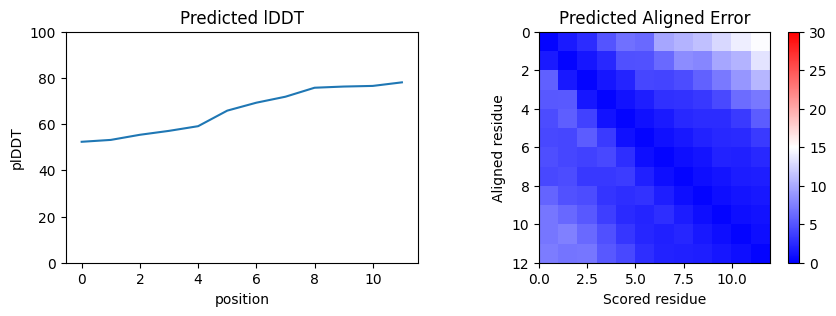

In [2]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?
sequence = "AAAAAAAAAAAA"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

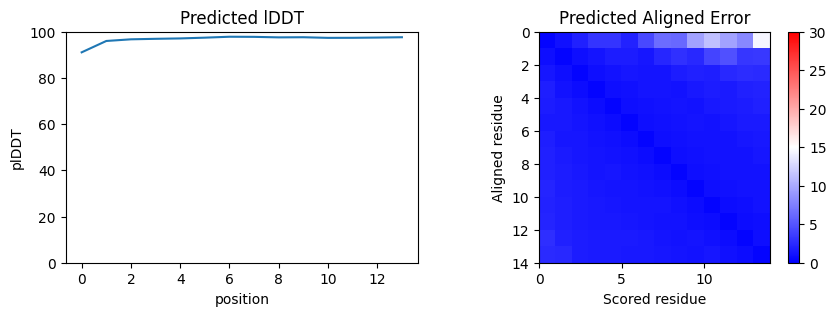

In [3]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?
sequence = "LLLLLLLLLLLLLL"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

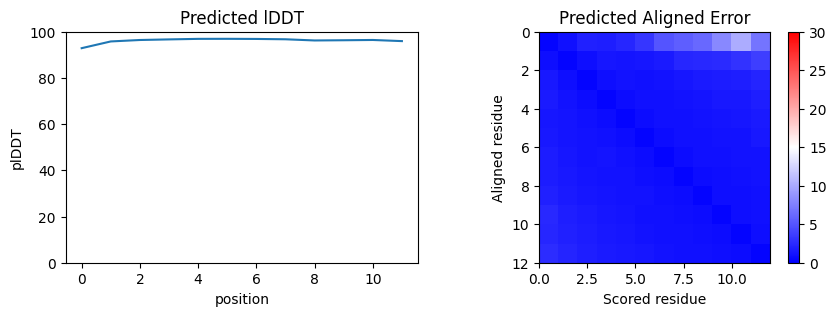

In [4]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?
sequence = "VVVVVVVVVVVV"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

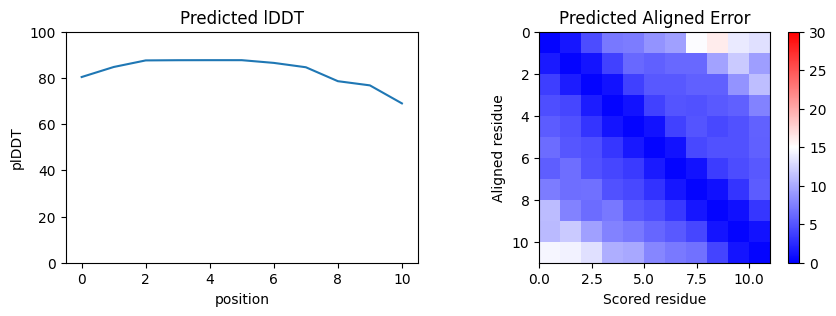

In [5]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?
sequence = "PPPPPPPPPPP"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

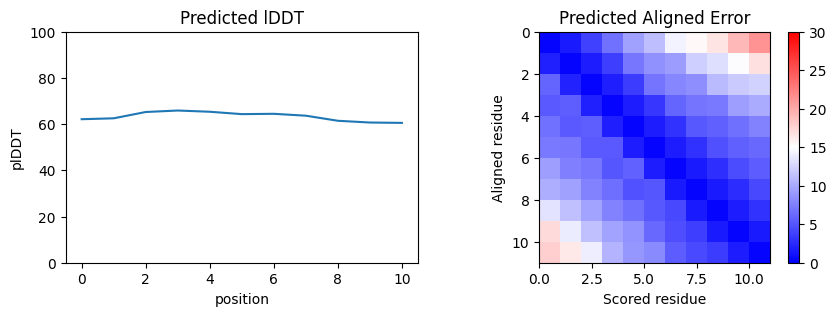

In [6]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?
sequence = "CCCCCCCCCCC"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

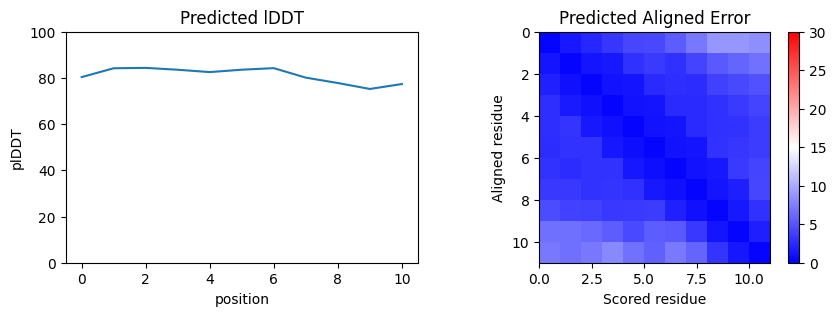

In [7]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?
sequence = "WWWWWWWWWWW"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

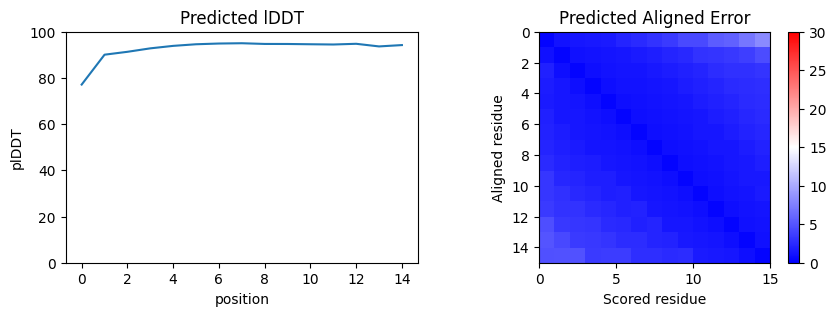

In [8]:
# Cell 3: Predict Structure for a Sequence

# @title Change the sequence of aminoacids to a different one (e.g. all Alanines, all Leucines, etc.). What is the difference in the predicted structure?
sequence = "YYYYYYYYYYYYYYY"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence=sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

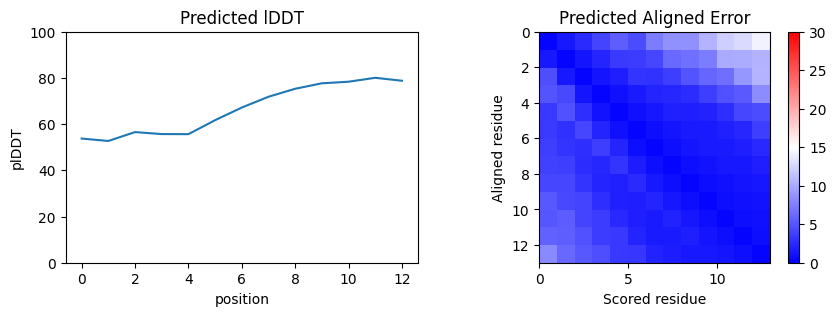

In [9]:
# Cell 3: Predict Structure for a Sequence

# @title Design sequences that fold into a ALPHA HELIX secondary structures (see figure above)
sequence = "AAAAAAAAAAAAA"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

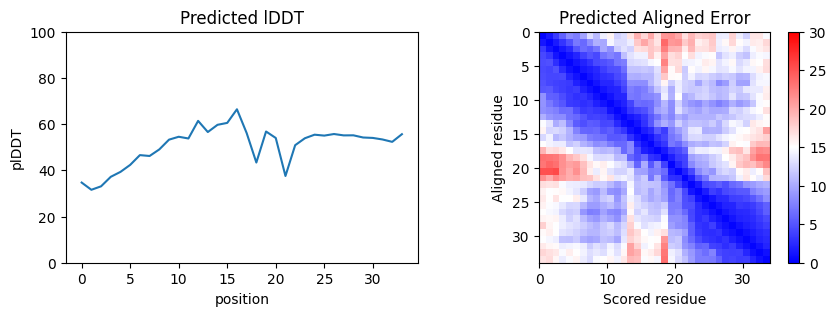

In [13]:
# Cell 3: Predict Structure for a Sequence

# @title Design sequences that fold into TWO HELICES (see figure above)
sequence = "AAAAAAAAAAAAAQFLIWQKWEAAAAAAAAAAAA"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

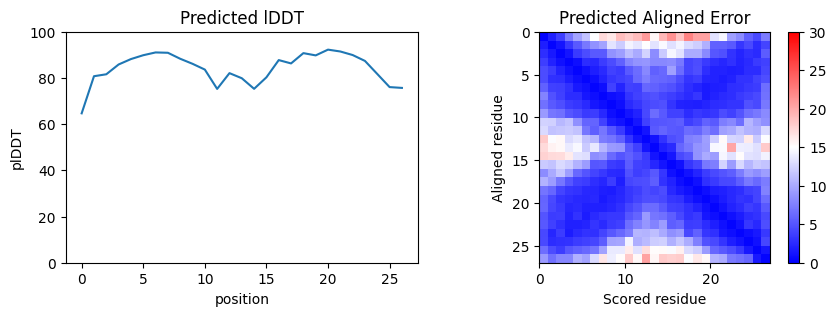

In [26]:
# Cell 3: Predict Structure for a Sequence

# @title Design sequences that fold into BETA SHEETS (see figure above)
sequence = "KKKVKVKFTTNTAWYATNTVDFEYEED"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


  0%|          | 0/49 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=48


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

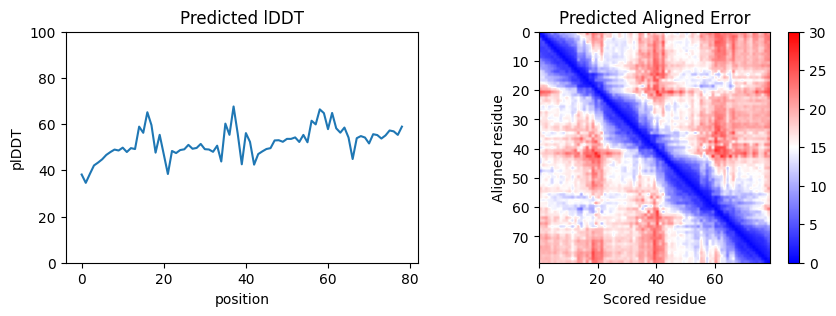

In [14]:
# Cell 3: Predict Structure for a Sequence

# @title Design a sequence that fold into 4 helix bundle (take a look at e.g. 3VJF)
sequence = "AAAAAAAAAAAAAQFLIWQKWEAAAAAAAAAAAAQFLIWQKWEAAAAAAAAAAAAQFLIWQKPGTWEAAAAAAAAAAAA"  # @param {type:"string"}
recycles = 48  # @param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
color = "rainbow"  # @param ["chain", "confidence", "rainbow"]
show_sidechains = True  # @param {type:"boolean"}
show_mainchains = True  # @param {type:"boolean"}

predict_structure(
    sequence,
    recycles=recycles,
    color=color,
    show_sidechains=show_sidechains,
    show_mainchains=show_mainchains,
)


## For the project

Let's put into practice what we have learned so far.
We will use Alphafold to predict the structure of a protein and then we will try to disrupt it by introducing mutations.

Tasks:
1. Go to the official [Alphafold2](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) notebook or [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb), read the instructions and predict the structure of your protein its sequence as an input. **Important Note**: There is a high probability that your protein is already in the database. Look in the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/).  If so, download the model and respond to the following questions.

    Questions:
    - what is the confidence score of your prediction?
    - what are the most confident regions?
    - align your crystal structure with the predicted one. What is the RMSD? (To calculate the RMSD between two proteins, you can use PyMol, load the two structures and use the command `rms_cur protein1 protein2` to get the value)

2. Use Alphafold or ColabFold to find a (minimum) set of mutations to disrupt your protein.

    Questions:
    - what are the most common disruptive mutations?
    - are there subsets in your list of mutations? Disrupting different regions or functions?



**Hint**: consider the following table of stabilizing forces in proteins

 <img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/w2023/ex02/structure_stabilizing_forces.png?raw=1" alt="Drawing"/>

**Hint 2**: Use your knowledge to analyze a multiple sequence alignment (MSA). You can use [Clustal Omega](https://toolkit.tuebingen.mpg.de/tools/clustalo) or [MAFFT](https://toolkit.tuebingen.mpg.de/tools/mafft).

Go [Here](https://colab.research.google.com/github/yerkoescalona/structural_bioinformatics/blob/main/ex02/msa.ipynb) for an example. With this notebook you can perform a multiple sequence alignment on a series of FASTA sequences (FtsZ sequences as example).




Happy modeling!